# Neural Networks - Part 2

In [31]:
import torch
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

## General Setup

The layers in between the input and output layer are called hidden layers. There is no special meaning to this phrase; it simply indicates that these neurons are performing intermediate calculations. __Deep Learning__ is a loosely defined term which implies that many hidden layers are being used.

The general setup consider $L$ layers, with layers 1 and $L$ being the input and output layers, respectiveley. Suppose that layer $l$, for $l=1, 2, \ldots, L$ contains $n_l$ neurons. So $n_1$ is the dimension of the input data.

$$
\begin{aligned}
a^{[1]} &= x \\
a^{[l]} &= \sigma \left( W^{[l]} a^{[l-1]} + b^{[l]} \right) \quad \text{for } l=2, 3, \ldots, L.
\end{aligned}
$$

Now suppose we have $N$ samples of training data,
$$
\left\{ x^{\{i\}} \right\}_{i=1}^N \subset \mathbb{R}^{n_1}
$$
for which there are given target outputs
$$
\left\{ y^{\{i\}} \right\}_{i=1}^N \subset \mathbb{R}^{n_L}
$$

Let's do a classification task with the same MNIST dataset but using PyTorch. Nowadyays, there are many Neural Network / Deep Learning frameworks availables, such as Tensorflow, Keras, JAX, Matlab, etc. We decided to use PyTorch since it has a really friendly user API.

First of all, we need the data. The way to access to it is different to scikit-learn, but it is essentialy the same but we load train and test sets in a separate way. Also, since the elements are images it is necessary to cast them to tensors.

In [32]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [33]:
training_data.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [34]:
training_data.data.shape

torch.Size([60000, 28, 28])

In [35]:
training_data.targets.shape

torch.Size([60000])

In [36]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [37]:
test_data.targets.shape

torch.Size([10000])

Let's see some samples again.

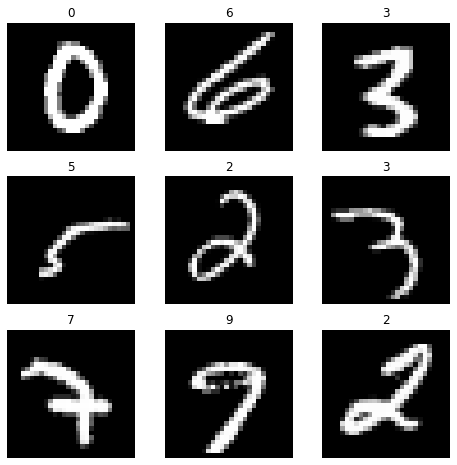

In [38]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

`DataLoader` is a tool for handle batches and iterate over the dataset.

In [39]:
batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


Note the size of each batch, in particular `X`-batches are made of only one channel and 28 $\times$ 28 pixels.

## Model

Before creating our model we need to select the device where PyTorch is going to work on. By default tensors are created on the CPU, but with the following line we can use the GPU (if it is available).

__Remark:__ If you running this notebook on Google Colab you need to enable GPU manually. Go to Menu `Menu > Runtime > Change Runtime` and change hardware accelaration to __GPU__.

In [40]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


To define a neural network in PyTorch, we create a class that inherits from `nn.Module`. We define the layers of the network in the `__init__` function and specify how data will pass through the network in the forward function.

In [41]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


We just created a fully connected neural network made of three layers (just one hidden layer). Note the activation function is not a logistic one, but another non-linear function calle _ReLU_ (Rectified Linear Unit) defined as 

$$
ReLu(x) = \max(0, x)
$$

![ReLU](../images/ReLU.png)

[Source](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)

## Optimization

The quadratic cost function that we widh to minimize hast the form

$$
J\left(W, b\right) = \frac{1}{N} \sum_{i=1}^N \frac{1}{2} \left\lVert y^{\{i\}} - a^{[L]} \left(x^{\{i\}}\right) \right\rVert^2_2
$$

where $W$, $b$ are the set of all the weight matrices and biases vectors, respectively.

We can minimize the cost function with gradient descent as we already saw previously. Without loss of generality, consider $J: \mathbb{R}^s \to \mathbb{R}$ and $\theta \in \mathbb{R}^s$, then the algorithm has the following form

$$
\theta \to \theta - \alpha \nabla J(\theta)
$$

where $\alpha$ is the learning rate and the partial derivative of the cost function is a sum over the training data of individual partial derivatives, more precisely

$$
\nabla J(\theta) = \frac{1}{N} \sum_{i=1}^N \nabla C_{x^{\{i\}}}(\theta)
$$

Now, we have to choose a loss (cost) function and the optimizer. 

- Cross Entropy is useful when training a classification problem with several classes. In this cases, 10 digits.
- Stochastic Gradient Descent with a learning rate of 0.001 (it is a standard practice to use this value as first guest).

In [42]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

### Stochastic Gradient Descent

When we have a large number of parameters and a large number of training points, computing the gradient vector at every iteration of the steepest descent method can be prohibitively expensive. A cheaper alternative is __*Stochastic Gradient Descent*__ which has several variations, one of the most commons is to take a smaller set of training data in each iteration. For some $m \ll N$ each iteration has the following form:

1. Choose $m$ integers, $k_1, k_2, \ldots, k_m$ uniformly at random from $\{1, 2, \ldots, N\}$.
2. Update 
$$
\theta \to \theta - \alpha \frac{1}{m} \sum_{i=1}^m \nabla C_{x^{\{k_i\}}}(\theta)
$$

In this iteration, the set $\{ x^{\{k_i\}} \}_{i=1}^k$ is known as a _minibatch_. There is a without replacement alternative where, assuming $N = Km$ for some $K$, we split the training set randomly into $K$ distinct minibatches and cycle through them.

### Back Propagation

Our task is to compute partial derivatives of the cost function with respect to each element of $W^{[l]}$ and $b^{[l]}$. We therefore focus our attention on computing those individual partial derivatives.

Hence, for a fixed $i$-th training sample we want to compute the derivatives of $C_{x^{\{i\}}}$, so we may drop the dependence on $x^{\{i\}}$ and simply write

$$
C = \frac{1}{2} \left\lVert y - a^{[L]}\right\rVert_2^2
$$

It is useful introduce two further sets of variables. First we let
$$
z^{[l]} = W^{[l]} a^{[l-1]} + b^{[l]} \in \mathbb{R}^{n_l} \quad \text{for} \; l=2, 3, \ldots, L.
$$
where $z_j^{[l]}$, the $j$-th component of $z_j^{[l]}$ is the _weighted input_ for neuron $j$ at layer $l$.

Secondly,
$$
\delta_j^{[l]} = \dfrac{\partial C}{\partial z_j^{[l]}} \in \mathbb{R}^{n_l} \quad \text{for} \; 1 \leq j \leq n_l \quad \text{and} \quad 2 \leq l \leq L
$$

The output $a^{[L]}$ can be evaluated from a forward pass through the network, computing in order
$$
a^{[1]}, z^{[2]}, a^{[2]}, z^{[3]}, a^{[3]}, \ldots, z^{[L]}, a^{[L]}
$$
Then,
$$
\delta^{[L-1]}, \delta^{[L-2]}, \ldots, \delta^{[2]}
$$
can be computed in backward pass such that 
$$
\dfrac{\partial C}{\partial W^{[l]}_{j, k}} = \delta_j^{[l]} a_k^{[l-1]}
\quad
\text{and}
\quad
\dfrac{\partial C}{\partial \beta^{[l]}_j} = \delta^{[l]}_j
\quad
\text{for} \; 1 \leq j, k \leq n_l \quad \text{and} \quad 2 \leq l \leq L
$$

Computing gradients in this way is known as __*back propagation*__.

Another good resource for understand back propagation is [this website](https://colah.github.io/posts/2015-08-Backprop/).

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model’s parameters.

In [43]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We also check the model’s performance against the test dataset to ensure it is learning.

In [44]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Finally, we have to decide the number of _epochs_ and just train the data. Sometimes epochs and batch size confuse people.

- The batch size is a hyperparameter of gradient descent that controls the number of __training samples__ to work through before the model’s internal parameters are updated.
- The number of epochs is a hyperparameter of gradient descent that controls the number of __complete passes through the training dataset__.

In [45]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.307937  [    0/60000]
loss: 2.306705  [ 6400/60000]
loss: 2.298175  [12800/60000]
loss: 2.282872  [19200/60000]
loss: 2.289108  [25600/60000]
loss: 2.291603  [32000/60000]
loss: 2.272025  [38400/60000]
loss: 2.273087  [44800/60000]
loss: 2.266502  [51200/60000]
loss: 2.256920  [57600/60000]
Test Error: 
 Accuracy: 28.5%, Avg loss: 2.259253 

Epoch 2
-------------------------------
loss: 2.260177  [    0/60000]
loss: 2.256225  [ 6400/60000]
loss: 2.255603  [12800/60000]
loss: 2.222483  [19200/60000]
loss: 2.240228  [25600/60000]
loss: 2.242202  [32000/60000]
loss: 2.213277  [38400/60000]
loss: 2.229506  [44800/60000]
loss: 2.207494  [51200/60000]
loss: 2.191150  [57600/60000]
Test Error: 
 Accuracy: 54.8%, Avg loss: 2.196347 

Epoch 3
-------------------------------
loss: 2.197476  [    0/60000]
loss: 2.187516  [ 6400/60000]
loss: 2.193516  [12800/60000]
loss: 2.134229  [19200/60000]
loss: 2.166577  [25600/60000]
loss: 2.165516  [32000/600

Sources:

- [Deep Learning: An Introduction for Applied Mathematicians](https://epubs.siam.org/doi/10.1137/18M1165748)
- [PyTorch Tutorial](https://pytorch.org/tutorials/beginner/basics/intro.html)